Project: Baryon mass fraction from galaxies at z=0 from survey

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import astropy.units as u
import scipy
from astropy import constants as const
from scipy import optimize
import scipy.integrate as integrate
from scipy.integrate import quad 
from scipy.special import *
import math


In [1]:
# Sersic general equation for any n. Eq. 2.22 from Galaxy Formation & Evolution 
# Need to define Reff first
# Bn 2n-0.324 (but only for n=>1) (B beta)
# To write I(R) in terms of L_tot instead of I0:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n))} exp[-bn(R/Re)**(1/n)]
# To write I(R) in terms of L_tot instead of Ie:
#         I(R)= {(L_tot*bn**2n)/(2*pi*Re**2*G(2n)*exp(bn))} exp[-bn{(R/Re)**(1/n)-1}]

def I0_to_Ie(I0):
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324 
    
    return I0/np.exp(Bn)

def Ie_to_I0(Ie):
    #units Lsun / kpc**2
    
    Bn = 2*n-0.324 
    
    return Ie*np.exp(Bn)
    
    

def Ltot_to_I0(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns I0
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function
    
    I0 = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm
    
    return I0

def Ltot_to_Ie(Ltot, Re, n):
    # Function that transform a given luminosity to I0 from eq 2.22 and 2.24
    # Takes in total luminosity, effective radius and sersic index
    # Returns I0
    # Ltot*(Bn)**(2n) / Re**2/(2*np.pi*n)/gamma
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function
    
    Ie = Ltot*(Bn)**(2*n) / Re**2/(2*np.pi*n)/gm/np.exp(Bn)
    
    return Ie
    

def sersic_profile(Ie, n, Re, r):
    # I0 puede ser L_tot
    # The surface brightness profile of spheroidal galaxies is generally well fit by the Sersic profile
    # Compare to sersic mass density 
    # I(R) = I0*exp[-Bn(R/Re)**(1/n)] = Ie*exp[-Bn{(R/Re)**(1/n)-1}]
    # Ie = I0/exp(Bn)
    # units are Lsun / kpc**2
   
    Bn = 2*n-0.324
    ratio = (r/Re)**(1/n)
    exponent = -Bn*(ratio-1)
    
    return Ie*np.exp(exponent)



def L_profile (r, Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR)
    # integrate sersic profile from 0 to R
    
    def L(r, Ie, n, Re):
        
        return 2*np.pi*sersic_profile(Ie, n, Re, r)*r
    
    I = integrate.quad(L, 0., r, args=(Ie, n, Re))
    
    ansI = I[0]
    
    return ansI

def L_tot (Ie, n, Re):
    # Total luminosity. Eq. 2.24 from Galaxy Formation & Evolution 
    # The total luminosity of a spherical system with a Sersic profile is given by this equation.
    # Compare to mass_prof_disk/sph from old code 
    # L = 2*pi*integral(I(R)RdR) = (2*pi*G(2n)/(Bn)**(2*n))*I0*Re**2
    # integrate sersic profile from 0 to inf
    
    Bn = 2*n-0.324
    
    gm = gamma(2*n)  #gamma function
    
    I0 = Ie*np.exp(Bn)    
    
    L = (2*pi*gm/(Bn)**(2*n))*I0*Re**2
    
    return L

# Also use 2.24 to get the eff radius L = 2*pi*int(I(R)dR)
# L(Re) - .5 L = 0 
# bisector: some sort of Newton's approx. .1kpc - 40 kpc

def avg_rad_eff(r, Ie, n, L):
# L represents the total galaxy luminosity, different from L_tot
    
    
    def f(r, Ie, n,  L):
        
        return L*.5 - L_profile (r, Ie, n, Re)
    
    r_l = optimize.bisect(f, 0.1, 40, args=(Ie, ))
    
    return r_l

##### Similar functions from old code


def mass_profile(r, Ms, z):
    #RP 2017 EQ: 61
    #input: stellar mass (solar mass), redshift, radius(kpc)
    #units: Msun 
    
    
    def M_rad(r, Ms, z):
        
        return  2 * np.pi * mass_density_avg(Ms, z, r) * r
    
    I = integrate.quad(M_rad, 0., r, args=(Ms, z))
    
    ansI = I[0]
    
    return ansI

def avg_rad_eff(Ms, z):
    
    def f(r, Ms, z):
        
        return (Ms/2) - mass_profile(r, Ms, z)
    
    r_m2 = optimize.bisect(f, 0, 100, args=(Ms, z))
    
    return r_m2


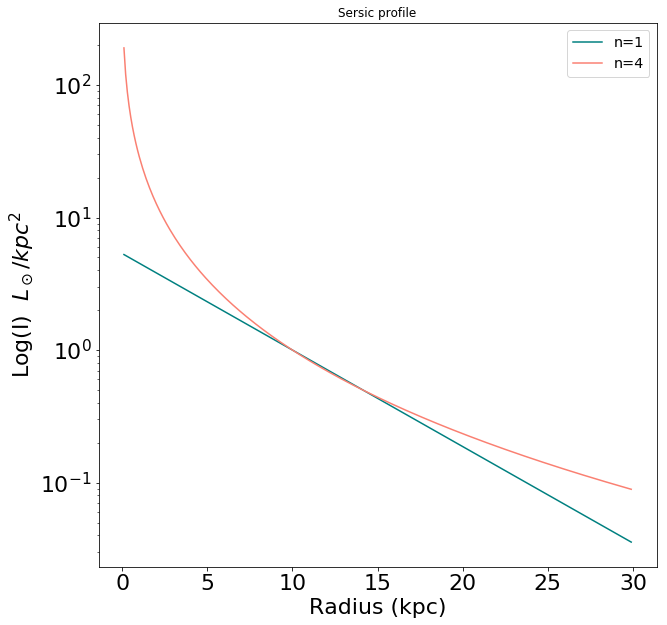

In [14]:
#r =  np.logspace(-2, 1.4, 100)

r = np.arange(0.1, 30, 0.1)

sm_n025 = sersic_profile(1, 0.25, 10, r)
sm_n050 = sersic_profile(1, 0.50, 10, r)
sm_n1 = sersic_profile(1, 1, 10, r)
sm_n4 = sersic_profile(1, 4, 10, r)
sm_n8 = sersic_profile(1, 8, 10, r)

fig = plt.figure(figsize=(10,10))
ax = plt.subplot(111)

plt.title('Sersic profile')
plt.semilogy(r, (sm_n1), '-', color='teal', label='n=1')
plt.semilogy(r, (sm_n4), '-', color='salmon', label='n=4')
#plt.semilogy(r, (sm_n8), '-', color='plum', label='n=8')
#plt.semilogy(r, (sm_n025), '-', color='turquoise', label='n=0.25')
#plt.semilogy(r, (sm_n050), '-', color='gold', label='n=0.50')
label_size = 22
matplotlib.rcParams['xtick.labelsize'] = label_size 
matplotlib.rcParams['ytick.labelsize'] = label_size
plt.xlabel('Radius (kpc)', fontsize=22)
plt.ylabel('Log(I)  $L_\odot/kpc^2$', fontsize=22)
plt.legend(loc='upper right', fontsize = 'x-large')
plt.show()

In [ ]:
# at large radius make sure L-profile  is equal to Ltot
#at 30kpc or wherever it flattens

# L_profile (r, Ie, n, Re)
# L_tot (Ie, n, Re)

# 2 figures, L_prof, color vs radius, 